In [1]:
%load_ext autoreload
%autoreload 2

# Random Forest Regularizado
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Mejorar sobre baseline con Random Forest regularizado

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Estrategia Anti-Overfitting

- `max_depth=10`: Limitar profundidad de árboles
- `min_samples_leaf=5`: Mínimo 5 muestras por hoja
- `max_features=0.3`: Solo 30% features por árbol
- Cross-validation para validar

## 1. Setup

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [3]:
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min',
    'distancia_km', 'velocidad_promedio_kmh', 'num_termicas',
    'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

print(f"Dev: {dev.shape}, Test: {test.shape}")
print(f"Targets: {len(targets_reg)}")

Dev: (309, 181), Test: (78, 181)
Targets: 9


## 3. Preparar Features

In [4]:
# Usar modo simple (solo promedios)
X_dev, y_dev, X_test, y_test = preparar_datos(dev, test, targets_reg, modo='simple')

print(f"\nFeatures: {X_dev.shape[1]}")
print(f"Samples - Dev: {X_dev.shape[0]}, Test: {X_test.shape[0]}")
print(f"Ratio: {X_dev.shape[0]/X_dev.shape[1]:.1f}:1")


Features: 14
Samples - Dev: 309, Test: 78
Ratio: 22.1:1


## 4. Random Forest Regularizado

In [5]:
resultados_rf = []
modelos_rf = {}

print("="*70)
print("RANDOM FOREST - REGULARIZADO")
print("="*70)
print("max_depth=10, min_samples_leaf=5, max_features=0.3\n")

for target in targets_reg:
    print(f"\n{target}:")
    t0 = time()
    
    # Modelo regularizado
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        max_features=0.3,
        random_state=42,
        n_jobs=-1
    )
    
    # Cross-validation
    cv_scores = cross_val_score(rf, X_dev, y_dev[target], 
                                cv=5, scoring='r2', n_jobs=-1)
    
    # Entrenar en todo Dev
    rf.fit(X_dev, y_dev[target])
    modelos_rf[target] = rf
    
    # Predicciones
    y_pred_dev = rf.predict(X_dev)
    y_pred_test = rf.predict(X_test)
    
    # Métricas
    metrics_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)
    metrics_dev['split'] = 'Dev'
    metrics_dev['CV_mean'] = cv_scores.mean()
    metrics_dev['CV_std'] = cv_scores.std()
    
    metrics_test = evaluar_modelo(y_test[target], y_pred_test, target)
    metrics_test['split'] = 'Test'
    metrics_test['CV_mean'] = cv_scores.mean()
    metrics_test['CV_std'] = cv_scores.std()
    
    resultados_rf.append(metrics_dev)
    resultados_rf.append(metrics_test)
    
    # Calcular gap
    gap = metrics_dev['R2'] - metrics_test['R2']
    status = "🚨" if gap > 0.3 else ("⚠️" if gap > 0.15 else "✓")
    
    print(f"  CV:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Dev:  {metrics_dev['R2']:.4f}")
    print(f"  Test: {metrics_test['R2']:.4f}")
    print(f"  Gap:  {gap:.4f} {status}")
    print(f"  Tiempo: {time()-t0:.1f}s")

df_rf = pd.DataFrame(resultados_rf)
df_rf['modelo'] = 'RandomForest'

# Clipear R² negativos
df_rf['R2'] = df_rf['R2'].clip(lower=0)

print("\n" + "="*70)

RANDOM FOREST - REGULARIZADO
max_depth=10, min_samples_leaf=5, max_features=0.3


altura_max_m:
  CV:   0.5632 ± 0.1377
  Dev:  0.7858
  Test: 0.6314
  Gap:  0.1544 ⚠️
  Tiempo: 3.6s

ganancia_altura_m:
  CV:   0.5471 ± 0.1362
  Dev:  0.7734
  Test: 0.6006
  Gap:  0.1729 ⚠️
  Tiempo: 2.1s

duracion_min:
  CV:   0.4840 ± 0.1445
  Dev:  0.7328
  Test: 0.6741
  Gap:  0.0587 ✓
  Tiempo: 2.2s

distancia_km:
  CV:   0.5362 ± 0.1184
  Dev:  0.7545
  Test: 0.7136
  Gap:  0.0409 ✓
  Tiempo: 1.8s

velocidad_promedio_kmh:
  CV:   0.3163 ± 0.1414
  Dev:  0.6102
  Test: 0.5073
  Gap:  0.1029 ✓
  Tiempo: 0.7s

num_termicas:
  CV:   0.1314 ± 0.1343
  Dev:  0.4903
  Test: 0.3133
  Gap:  0.1770 ⚠️
  Tiempo: 0.7s

intensidad_termicas_mean_ms:
  CV:   -0.1224 ± 0.0734
  Dev:  0.3296
  Test: -0.1173
  Gap:  0.4469 🚨
  Tiempo: 0.7s

tiempo_en_termicas_min:
  CV:   0.4986 ± 0.1375
  Dev:  0.7429
  Test: 0.7043
  Gap:  0.0386 ✓
  Tiempo: 0.7s

tasa_ascenso_mean_ms:
  CV:   -0.1060 ± 0.0513
  Dev:  0.2927
  T

## 5. Comparación con Baseline

In [6]:
# Cargar baseline
df_baseline = pd.read_csv('../data/processed/resultados_hibrido.csv')

# Comparar solo Ridge/Dummy vs RF
df_comp = pd.concat([df_baseline, df_rf], ignore_index=True)
df_test_comp = df_comp[df_comp['split'] == 'Test'].copy()

print("="*70)
print("COMPARACIÓN: Baseline vs Random Forest (Test)")
print("="*70)

for target in targets_reg:
    r2_base = df_test_comp[df_test_comp['target']==target]['R2'].iloc[0]
    r2_rf = df_test_comp[df_test_comp['target']==target]['R2'].iloc[1]
    mejora = r2_rf - r2_base
    
    status = "✓✓" if mejora > 0.05 else ("✓" if mejora > 0 else "→")
    
    print(f"\n{target}:")
    print(f"  Baseline: {r2_base:.4f}")
    print(f"  RF:       {r2_rf:.4f}")
    print(f"  Mejora:   {mejora:+.4f} {status}")

print("\n" + "="*70)

COMPARACIÓN: Baseline vs Random Forest (Test)

altura_max_m:
  Baseline: 0.4333
  RF:       0.6314
  Mejora:   +0.1981 ✓✓

ganancia_altura_m:
  Baseline: 0.3543
  RF:       0.6006
  Mejora:   +0.2463 ✓✓

duracion_min:
  Baseline: 0.6523
  RF:       0.6741
  Mejora:   +0.0219 ✓

distancia_km:
  Baseline: 0.6245
  RF:       0.7136
  Mejora:   +0.0891 ✓✓

velocidad_promedio_kmh:
  Baseline: 0.4442
  RF:       0.5073
  Mejora:   +0.0631 ✓✓

num_termicas:
  Baseline: 0.1616
  RF:       0.3133
  Mejora:   +0.1518 ✓✓

intensidad_termicas_mean_ms:
  Baseline: 0.0000
  RF:       0.0000
  Mejora:   +0.0000 →

tiempo_en_termicas_min:
  Baseline: 0.6074
  RF:       0.7043
  Mejora:   +0.0969 ✓✓

tasa_ascenso_mean_ms:
  Baseline: 0.0000
  RF:       0.0000
  Mejora:   +0.0000 →



## 6. Feature Importance

In [7]:
# Top 5 features por target
print("="*70)
print("FEATURE IMPORTANCE (Top 5 por target)")
print("="*70)

for target in targets_reg:
    rf = modelos_rf[target]
    importances = pd.DataFrame({
        'feature': X_dev.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n{target}:")
    for _, row in importances.head(5).iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:.4f}")

FEATURE IMPORTANCE (Top 5 por target)

altura_max_m:
  skin_temp_avg                 : 0.2074
  pressure_avg                  : 0.1228
  boundary_layer_height_avg     : 0.1054
  temp_2m_avg                   : 0.0832
  lat_despegue                  : 0.0831

ganancia_altura_m:
  skin_temp_avg                 : 0.2075
  pressure_avg                  : 0.1274
  boundary_layer_height_avg     : 0.1040
  solar_rad_avg                 : 0.0819
  temp_2m_avg                   : 0.0784

duracion_min:
  hora_despegue_decimal         : 0.2472
  temp_2m_avg                   : 0.1065
  skin_temp_avg                 : 0.1039
  lon_despegue                  : 0.0893
  boundary_layer_height_avg     : 0.0892

distancia_km:
  hora_despegue_decimal         : 0.1703
  temp_2m_avg                   : 0.1537
  skin_temp_avg                 : 0.1364
  lat_despegue                  : 0.1090
  boundary_layer_height_avg     : 0.0886

velocidad_promedio_kmh:
  lat_despegue                  : 0.1931
  skin_temp

## 7. Visualización

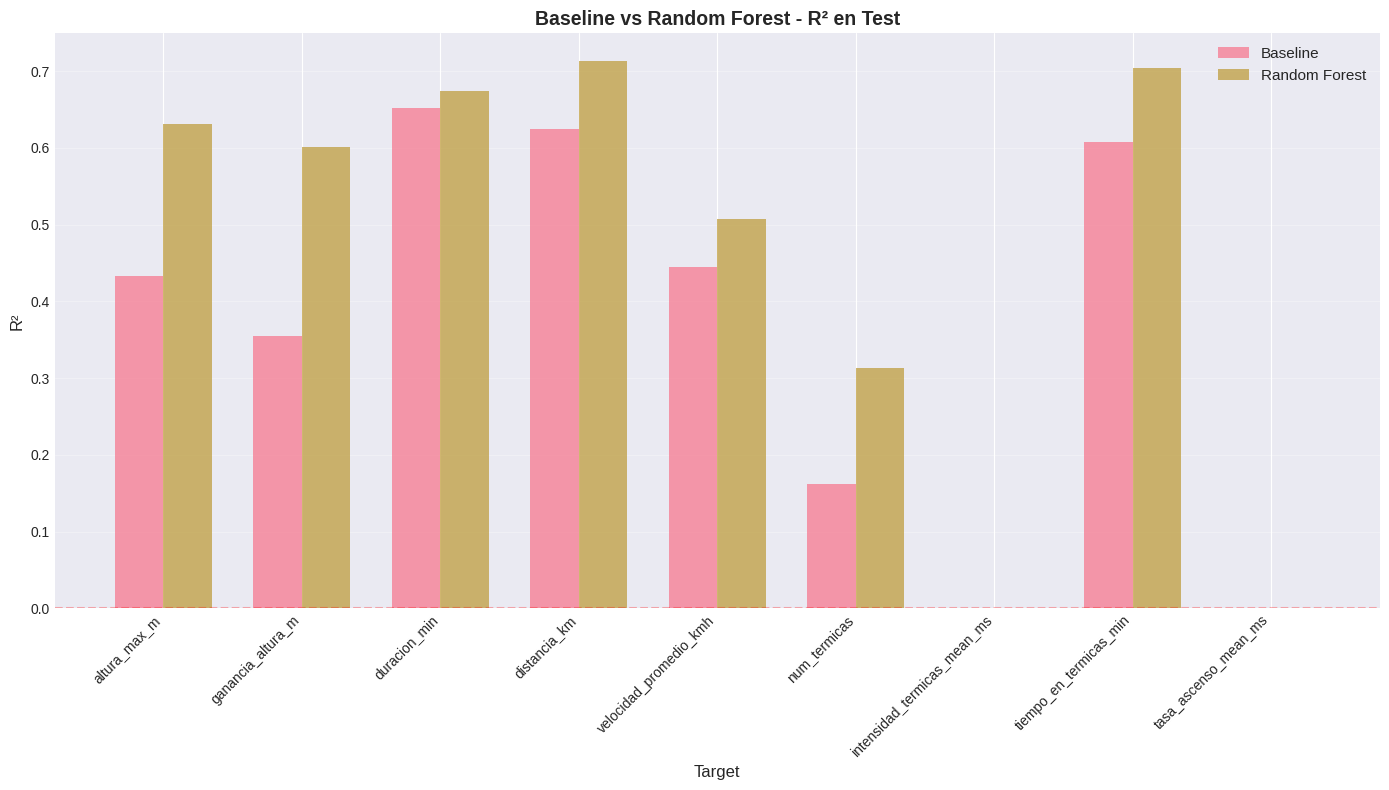

In [8]:
# Gráfico comparativo
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.35

r2_baseline = []
r2_rf = []

for target in targets_reg:
    r2_base = df_test_comp[df_test_comp['target']==target]['R2'].iloc[0]
    r2_forest = df_test_comp[df_test_comp['target']==target]['R2'].iloc[1]
    r2_baseline.append(r2_base)
    r2_rf.append(r2_forest)

ax.bar(x - width/2, r2_baseline, width, label='Baseline', alpha=0.7)
ax.bar(x + width/2, r2_rf, width, label='Random Forest', alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('Baseline vs Random Forest - R² en Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/rf_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Guardar Resultados

In [9]:
df_rf.to_csv('../data/processed/resultados_rf.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/resultados_rf.csv")
print("  - data/processed/rf_vs_baseline.png")
print("\n" + "="*70)
print("✓ RANDOM FOREST (FEATURES SIMPLES) COMPLETADO")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/resultados_rf.csv
  - data/processed/rf_vs_baseline.png

✓ RANDOM FOREST (FEATURES SIMPLES) COMPLETADO


---
# PARTE 2: Random Forest con Features COMPLETAS

Probar si features horarias (09h-18h) mejoran targets problemáticos:
- intensidad_termicas_mean_ms
- tasa_ascenso_mean_ms

## 9. Preparar Features Completas

In [10]:
# Usar TODAS las features horarias
X_dev_full, y_dev_full, X_test_full, y_test_full = preparar_datos(
    dev, test, targets_reg, modo='completo'
)

print(f"\nFeatures COMPLETAS: {X_dev_full.shape[1]}")
print(f"Samples - Dev: {X_dev_full.shape[0]}, Test: {X_test_full.shape[0]}")
print(f"Ratio: {X_dev_full.shape[0]/X_dev_full.shape[1]:.1f}:1")
print(f"\n⚠️ Ratio bajo - regularización más agresiva necesaria")


Features COMPLETAS: 113
Samples - Dev: 309, Test: 78
Ratio: 2.7:1

⚠️ Ratio bajo - regularización más agresiva necesaria


## 10. RF con Features Completas (REGULARIZACIÓN AGRESIVA)

In [11]:
resultados_rf_full = []
modelos_rf_full = {}

print("="*70)
print("RANDOM FOREST - FEATURES COMPLETAS (110+)")
print("="*70)
print("max_depth=8, min_samples_leaf=8, max_features=0.2 (más restrictivo)\n")

for target in targets_reg:
    print(f"\n{target}:")
    t0 = time()
    
    # Regularización MÁS AGRESIVA (ratio bajo)
    rf_full = RandomForestRegressor(
        n_estimators=100,
        max_depth=8,           # Más bajo que antes
        min_samples_leaf=8,    # Más alto que antes
        max_features=0.2,      # Menos features por árbol
        random_state=42,
        n_jobs=-1
    )
    
    # Cross-validation
    cv_scores = cross_val_score(rf_full, X_dev_full, y_dev_full[target],
                                cv=5, scoring='r2', n_jobs=-1)
    
    # Entrenar
    rf_full.fit(X_dev_full, y_dev_full[target])
    modelos_rf_full[target] = rf_full
    
    # Predicciones
    y_pred_dev = rf_full.predict(X_dev_full)
    y_pred_test = rf_full.predict(X_test_full)
    
    # Métricas
    metrics_dev = evaluar_modelo(y_dev_full[target], y_pred_dev, target)
    metrics_dev['split'] = 'Dev'
    metrics_dev['CV_mean'] = cv_scores.mean()
    metrics_dev['CV_std'] = cv_scores.std()
    
    metrics_test = evaluar_modelo(y_test_full[target], y_pred_test, target)
    metrics_test['split'] = 'Test'
    metrics_test['CV_mean'] = cv_scores.mean()
    metrics_test['CV_std'] = cv_scores.std()
    
    resultados_rf_full.append(metrics_dev)
    resultados_rf_full.append(metrics_test)
    
    # Gap
    gap = metrics_dev['R2'] - metrics_test['R2']
    status = "🚨" if gap > 0.3 else ("⚠️" if gap > 0.15 else "✓")
    
    print(f"  CV:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Dev:  {metrics_dev['R2']:.4f}")
    print(f"  Test: {metrics_test['R2']:.4f}")
    print(f"  Gap:  {gap:.4f} {status}")
    print(f"  Tiempo: {time()-t0:.1f}s")

df_rf_full = pd.DataFrame(resultados_rf_full)
df_rf_full['modelo'] = 'RF_Full'
df_rf_full['R2'] = df_rf_full['R2'].clip(lower=0)

print("\n" + "="*70)

RANDOM FOREST - FEATURES COMPLETAS (110+)
max_depth=8, min_samples_leaf=8, max_features=0.2 (más restrictivo)


altura_max_m:
  CV:   0.5508 ± 0.1240
  Dev:  0.7416
  Test: 0.6323
  Gap:  0.1093 ✓
  Tiempo: 0.7s

ganancia_altura_m:
  CV:   0.5315 ± 0.1223
  Dev:  0.7281
  Test: 0.6021
  Gap:  0.1261 ✓
  Tiempo: 0.7s

duracion_min:
  CV:   0.4426 ± 0.1165
  Dev:  0.6634
  Test: 0.6063
  Gap:  0.0571 ✓
  Tiempo: 0.6s

distancia_km:
  CV:   0.4932 ± 0.0970
  Dev:  0.6931
  Test: 0.6661
  Gap:  0.0270 ✓
  Tiempo: 0.6s

velocidad_promedio_kmh:
  CV:   0.2734 ± 0.1250
  Dev:  0.5222
  Test: 0.4261
  Gap:  0.0961 ✓
  Tiempo: 0.7s

num_termicas:
  CV:   0.1248 ± 0.1404
  Dev:  0.4008
  Test: 0.2744
  Gap:  0.1263 ✓
  Tiempo: 0.7s

intensidad_termicas_mean_ms:
  CV:   -0.1354 ± 0.0937
  Dev:  0.2548
  Test: -0.1676
  Gap:  0.4224 🚨
  Tiempo: 0.8s

tiempo_en_termicas_min:
  CV:   0.4649 ± 0.0903
  Dev:  0.6710
  Test: 0.6604
  Gap:  0.0106 ✓
  Tiempo: 0.7s

tasa_ascenso_mean_ms:
  CV:   -0.0918 

## 11. Comparación: RF Simple vs RF Full

In [12]:
print("="*70)
print("COMPARACIÓN: RF Simple (14 features) vs RF Full (110+ features)")
print("="*70)

mejoras = []

for target in targets_reg:
    r2_simple = df_rf[(df_rf['target']==target) & (df_rf['split']=='Test')]['R2'].values[0]
    r2_full = df_rf_full[(df_rf_full['target']==target) & (df_rf_full['split']=='Test')]['R2'].values[0]
    
    gap_simple = df_rf[(df_rf['target']==target) & (df_rf['split']=='Dev')]['R2'].values[0] - r2_simple
    gap_full = df_rf_full[(df_rf_full['target']==target) & (df_rf_full['split']=='Dev')]['R2'].values[0] - r2_full
    
    mejora = r2_full - r2_simple
    mejoras.append({'target': target, 'mejora': mejora})
    
    status = "✓✓" if mejora > 0.05 else ("✓" if mejora > 0 else ("→" if mejora > -0.05 else "❌"))
    
    print(f"\n{target}:")
    print(f"  Simple (14): {r2_simple:.4f} (gap: {gap_simple:.3f})")
    print(f"  Full (110):  {r2_full:.4f} (gap: {gap_full:.3f})")
    print(f"  Mejora:      {mejora:+.4f} {status}")

df_mejoras = pd.DataFrame(mejoras).sort_values('mejora', ascending=False)

print("\n" + "="*70)
print("RESUMEN:")
print("="*70)
mejoraron = len(df_mejoras[df_mejoras['mejora'] > 0])
empeoraron = len(df_mejoras[df_mejoras['mejora'] < 0])
print(f"Mejoraron: {mejoraron}/9")
print(f"Empeoraron: {empeoraron}/9")

if mejoraron > 5:
    print("\n✓✓ FEATURES COMPLETAS FUNCIONAN MEJOR")
elif empeoraron > 5:
    print("\n❌ OVERFITTING - Usar features simples")
else:
    print("\n→ RESULTADOS MIXTOS - Analizar caso por caso")

print("="*70)

COMPARACIÓN: RF Simple (14 features) vs RF Full (110+ features)

altura_max_m:
  Simple (14): 0.6314 (gap: 0.154)
  Full (110):  0.6323 (gap: 0.109)
  Mejora:      +0.0009 ✓

ganancia_altura_m:
  Simple (14): 0.6006 (gap: 0.173)
  Full (110):  0.6021 (gap: 0.126)
  Mejora:      +0.0015 ✓

duracion_min:
  Simple (14): 0.6741 (gap: 0.059)
  Full (110):  0.6063 (gap: 0.057)
  Mejora:      -0.0679 ❌

distancia_km:
  Simple (14): 0.7136 (gap: 0.041)
  Full (110):  0.6661 (gap: 0.027)
  Mejora:      -0.0475 →

velocidad_promedio_kmh:
  Simple (14): 0.5073 (gap: 0.103)
  Full (110):  0.4261 (gap: 0.096)
  Mejora:      -0.0812 ❌

num_termicas:
  Simple (14): 0.3133 (gap: 0.177)
  Full (110):  0.2744 (gap: 0.126)
  Mejora:      -0.0389 →

intensidad_termicas_mean_ms:
  Simple (14): 0.0000 (gap: 0.330)
  Full (110):  0.0000 (gap: 0.255)
  Mejora:      +0.0000 →

tiempo_en_termicas_min:
  Simple (14): 0.7043 (gap: 0.039)
  Full (110):  0.6604 (gap: 0.011)
  Mejora:      -0.0440 →

tasa_ascenso_me

## 12. Guardar Resultados Completos

In [13]:
df_rf_full.to_csv('../data/processed/resultados_rf_full.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/resultados_rf_full.csv")
print("\n" + "="*70)
print("✓ RANDOM FOREST (FEATURES COMPLETAS) COMPLETADO")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/resultados_rf_full.csv

✓ RANDOM FOREST (FEATURES COMPLETAS) COMPLETADO
